# Time Series Retail Sales Forecasting with DeepAR

Forecasting is a central problem in many businesses. In the retail industry probabilistic forecasts are important for inventory management to ensure that there is enough product on-hand to meet the seasonal spikes in sales for differnet categories of products. 

Most forecasting methods have been developed in the setting of forecasting individual time series where model parameters are independently estimated from past observations for each given time series. Today retailers are faced with forecasting demand on potentially millions of time series for different products across their catalog. Retailers also face cold start problems where they need to forecast for a new item that has no existing time series data. 

In this notebook we will see how the [DeepAR forecasting algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) can help retailers solve these business problems. Using a generated dataset of daily sales for a set of clothing products we will see how DeepAR can learn jointly across the related time series to capture complex group dependent behavior at a categorical level. Finally we will see how this learned categorical behavior can be used to forecast for products with existing time series as well as new "cold" products with no existing data.

For a more rigorous explaination of the DeepAR algorithm check out the [DeepAR white paper](https://pdfs.semanticscholar.org/4eeb/e0d12aefeedf3ca85256bc8aa3b4292d47d9.pdf).

## Importing modules and defining helper functions

The modules and helper functions below will be used throughout this lab to generate the dataset and convert data between formats. You do not need to read over and understand each function to proceed with the lab but comments have been added for the inquisitive to reference. Run the below cell before proceeding.

In [1]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sagemaker
import datetime
import tempfile
import random
import boto3
import copy
import uuid
import json
import os

%matplotlib inline


def make_product(categories, num_years):
    """ Creates a random product with a unique product id from the list of potential category and subcategory pairings
    
    Args:
        categories (dict): Dictionary containing mappings of categories to lists of subcategories.
        num_years (int): Range of years from today's date to pick start date for time series data from.
    Returns:
        (dict)
        Dictionary containing product information for the generated product.
    """
    product_id = str(uuid.uuid4().fields[-1])
    cat, subcats = random.choice(list(categories.items()))
    subcat = random.choice(subcats)
    start_date = datetime.date.today() - datetime.timedelta(random.randint(num_years/2, num_years)*365)
    return {'product_id': product_id, 
            'category': cat, 
            'subcategory': subcat, 
            'start_date': start_date}

def make_weights(categories, num_years):
    """ Creates normalized weights in the interval 0-1 for each category for each month of each year in the input range of years.
    
    Args:
        categories (dict): Dictionary containing mappings of categories to lists of subcategories.
        num_years (int): Range of years from today's date to pick start date for time series data from.
    Returns:
        (dict)
        Dictionary containing weights for each category for each month of each year in the input range of years.
    """
    end_year = datetime.date.today().year
    results = defaultdict(lambda: defaultdict(dict))
    for year in range(end_year-num_years, end_year+1):
        for month in range(1, 13):
            rands = np.random.random(size=len(categories))
            weights = rands / rands.sum()
            weight_index = 0
            for category in categories:
                results[category][year][month] = weights[weight_index]
                weight_index += 1
    return results

def make_category_weights(categories, num_years):
    """ Creates random weights for each category and subcategory to further augment seasonality within these groupings
    Weights are randomly created for every category and subcategory for each year and month
    At the category and subcategory levels the weights are normalized to sum to 1
    
    Args:
        categories (dict): Dictionary containing mappings of categories to lists of subcategories.
        num_years (int): Range of years from today's date to pick start date for time series data from.
    Returns:
        (dict)
        Dictionary containing weights for each category for each month of each year in the input range of years.
    """
    category_weights = make_weights(list(categories.keys()), num_years) # Create weights for the top level categories
    for category, subcategories in categories.items(): # Add weights for the corresponding subcategories
        subcat_weights = make_weights(subcategories, num_years)
        for subcat, weights in subcat_weights.items():
            category_weights[category][subcat] = weights
    return category_weights

def make_time_point_value(date, cat, subcat, seasonality, weights):
    """ Creates daily time point sales value for a product based on baseline seasonality and product weights
    
    Args:
        date (datetime): Date to generate time point value for.
        cat (string): Category of product.
        subcat (string): Subcategory of product.
        seasonality (dict): Dictionary containing details about seasonality of sales for products.
        weights (dict): Dictionary containing weights for each category and subcategory for each month of each year.
    Returns:
        (int)
        Time point sales value for a given product on a given day.
    """
    month = date.month
    year = date.year
    baseline = seasonality[month]
    noise = np.random.normal(scale=0.1)
    cat_weight = weights[cat][year][month]
    subcat_weight = weights[cat][subcat][year][month]
    value = (baseline + noise*baseline)*cat_weight*subcat_weight
    return int(value)

def make_data_for_product(product, seasonality, weights):
    """ Creates DataFrame containing time point sales values for input product based on baseline seasonality and product weights.
    
    Args:
        product (dict): Dictionary containing product information for a single product.
        seasonality (dict): Dictionary containing details about seasonality of sales for products.
        weights (dict): Dictionary containing weights for each category and subcategory for each month of each year.
    Returns:
        (DataFrame)
        DataFrame containing time point sales values for a given product.
    """
    cat = product['category']
    subcat = product['subcategory']
    today = datetime.date.today()
    start_date = product['start_date']
    delta = today - start_date
    data = []
    for i in range(delta.days + 1):
        local_product = product.copy()
        local_product.pop('start_date', None)
        date = start_date + datetime.timedelta(days=i)
        local_product['date'] = date
        local_product['sales'] = make_time_point_value(date, cat, subcat, seasonality, weights)
        data.append(local_product)
    return pd.DataFrame(data)    

def make_data_for_products(products, seasonality, weights):
    """ Creates DataFrame containing time point sales values for all input products based on baseline return seasonality and product weights.
    
    Args:
        products (list): List of dictionaries containing product information for all products.
        seasonality (dict): Dictionary containing details about seasonality of sales for products.
        weights (dict): Dictionary containing weights for each category and subcategory for each month of each year.
    Returns:
        (DataFrame)
        DataFrame containing time series sales values for a given product.
    """
    df = pd.concat([make_data_for_product(product, seasonality, weights) for product in products])
    df = df[['product_id', 'date', 'category', 'subcategory', 'sales']]
    df['product_id'] = df['product_id'].apply(str)
    df['date'] = df['date'].apply(lambda t: pd.to_datetime(t, format='%Y-%m-%d'))
    return df
    
def plot_dataset_ts(df, condition):
    """ Plots summed time point sales values of data at monthly granularity grouped by condition.
    
    Args:
        df (DataFrame): DataFrame containing time point sales data for products.
        condition (str): Condition to group DataFrame by ('category' or 'subcategory').
    Returns:
        (None)
    """
    data = df.copy()
    data = data.groupby(['date', condition]).sum().unstack().fillna(0.0)
    data = data.groupby([(data.index.year),(data.index.month)]).sum()
    fig, ax = plt.subplots(figsize=(15,15))
    data.plot(ax=ax)

def ts_to_json_obj(series, cat):
    """ Converts input time point DataFrame into a JSON object in DeepAR format
    
    Args:
        series (DataFrame): DataFrame containing time point sales data for a product.
        cat (str): Label encoded category for product.
    Returns:
        (dict)
        Dictionary containing time point sales data converted to DeepAR format.
    """
    ts = series.copy() # Make a local copy of series so as not to modify original DataFrame
    ts = ts.rename('sales') # Rename series
    ts = ts.reset_index() # Input series is indexed by date, re-index to make df with date as column
    start_date_index = ts['sales'].nonzero()[0][0] # Pull out index of first non-zero day of return values
    ts = ts.iloc[start_date_index:].reset_index(drop=True) # Truncate leading 0 return rows from time series and reset index to 0
    json_obj = {"start": str(ts['date'][0]), "cat": int(cat), "target": ts['sales'].astype(int).tolist()}
    return json_obj

def transform_to_json_objs(df, le):
    """ Converts input DataFrame of all time point sales values for all products into list of JSON objects in DeepAR format for each product.
    
    Args:
        df (DataFrame): DataFrame containing time point sales data for all products.
        le (LabelEncoder): SciKit LabelEncoder fit on product categories and subcategories to label encode these values with.
    Returns:
        (dict)
        Dictionary containing time point sales data converted to DeepAR format for all products.
    """
    cats_df = df[['product_id', 'category', 'subcategory']].drop_duplicates().set_index('product_id')
    ts_df = df.groupby(['date', 'product_id']).sum().unstack().fillna(0.0)
    ts_df.columns = ts_df.columns.droplevel() # Drop unneeded multi-index level
    json_objs = []
    for column in list(ts_df.columns.values):
        cat = cats_df.loc[column, 'category']
        subcat = cats_df.loc[column, 'subcategory']
        num_cat = le.transform([cat])[0]
        num_subcat = le.transform([subcat])[0]
        json_objs.append(ts_to_json_obj(ts_df.loc[:, column], num_cat))
        json_objs.append(ts_to_json_obj(ts_df.loc[:, column], num_subcat))
    return json_objs

def make_train_set(json_objs, prediction_length):
    """ Creates a training set from an input dataset by removing prediction_length number of time points from each time series.
    
    Args:
        json_objs (list): List of JSON objects in DeepAR format.
        prediction_length (int): Number of time points to remove from each time series.
    Returns:
        (list)
        List of JSON objects in DeepAR format where each object has had prediction_length number of time points removed.
    """
    objs = copy.deepcopy(json_objs)
    for obj in objs:
        obj['target'] = obj['target'][:-prediction_length]
    return objs

def write_json_to_file(json_objs, channel):
    """ Writes list of JSON objects to file in JSON Lines format encoded as utf-8. 
    Output file is named after channel.
    
    Args:
        json_objs (list): List of JSON objects in DeepAR format.
        channel (str): Channel that JSON Lines data will be used for ('train' or 'test').
    Returns:
        (str)
        Path of file data was written to.
    """
    file_name = '{}.json'.format(channel)
    file_path = os.path.join(os.getcwd(), file_name)
    with open(file_path, 'wb') as f:
        for obj in json_objs:
            line = json.dumps(obj) + '\n'
            line = line.encode('utf-8')
            f.write(line)
        f.seek(0)
        f.flush()
    return file_path
        

## Generating the dataset

For this lab we will be working with a dataset composed of category + subcategory pairings. The cell below generates a catalog of products using possible category + subcategory pairings from the `categories` dictionary of categories and subcategories. Each product is given a unique product ID to be identified by.

Next each product category and subcategory is given a random normalized weight for each month of each year in the time series range. These weights are used to simulate seasonality in different product categories and subcategories, such as boots being more popular in winter than in summer.

Lastly, time series sales data is generated for each product using the the product catalog, the normalized weights, and the `seasonality` dictionary, which is used to augment the sales values roughly around what a typical retailers yearly sales trends might look like. To simulate a store adding products over time each product is randomly assigned a "start" date in the time series interval in which it begins to have non-zero sales values.

In [2]:
# Categories and subcategories to generate products with
# Each product id is generated with a random category and subcategory from that category's options
categories = {
    'shoe': ['sneaker', 'boot', 'slipper'],
    'outerwear': ['coat', 'jacket', 'shell'],
    'top': ['shirt', 't-shirt', 'sweater', 'knit'],
    'bottom': ['skirt', 'pant', 'short', 'leggings'],
    'accessories': ['belt', 'tie', 'scarf', 'hat', 'brooche']
}

# Seasonality for time series data to be generated around
seasonality = {
    1: 500,
    2: 400,
    3: 200,
    4: 100,
    5: 40,
    6: 80,
    7: 150,
    8: 180,
    9: 140,
    10: 240,
    11: 100,
    12: 400
}

n_products = 100 # Number of products to generate. Increase this to generate more individual product data

n_years = 4 # Number of years in past from current date to generate date for. Increase this to generate longer time series for each product

products = [make_product(categories, n_years) for i in range(n_products)]

category_weights = make_category_weights(categories, n_years)

product_data = make_data_for_products(products, seasonality, category_weights)

print(product_data.head())

       product_id       date category subcategory  sales
0  11134790715283 2014-10-06   bottom       short     19
1  11134790715283 2014-10-07   bottom       short     17
2  11134790715283 2014-10-08   bottom       short     19
3  11134790715283 2014-10-09   bottom       short     20
4  11134790715283 2014-10-10   bottom       short     19


## Visualizing the data

Now that we have generated our dataset let's take a look at the time series sales values over time at the category and subcategory levels across products. This can be done by running the code in the cells below.

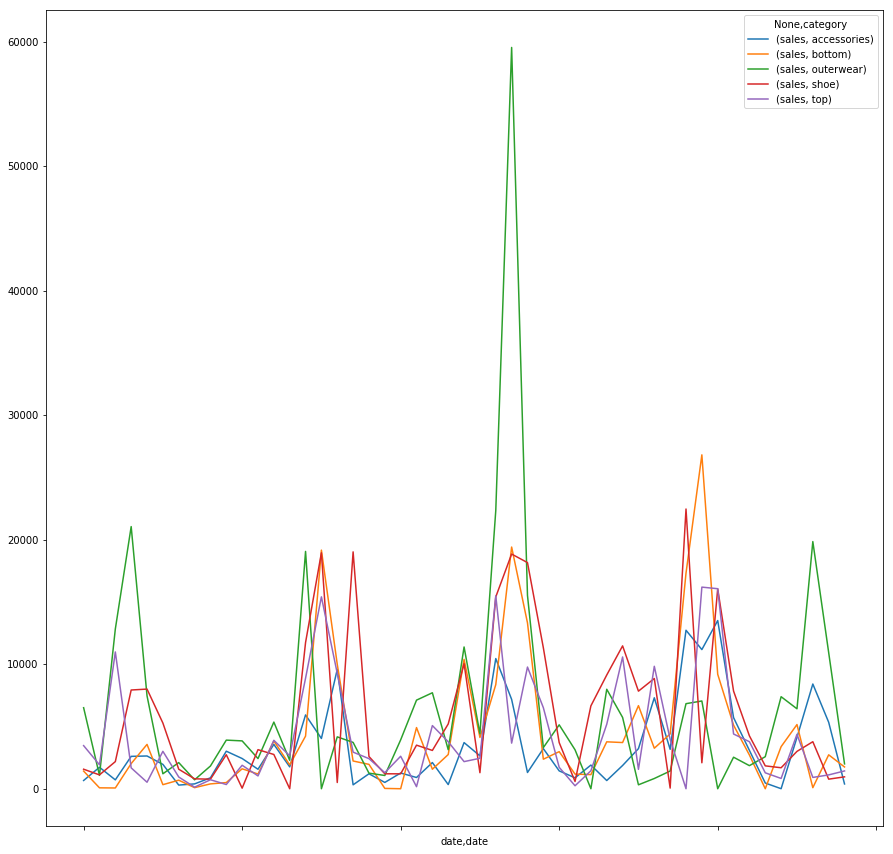

In [3]:
# Visualize monthly sales of products at category level
plot_dataset_ts(product_data, 'category')

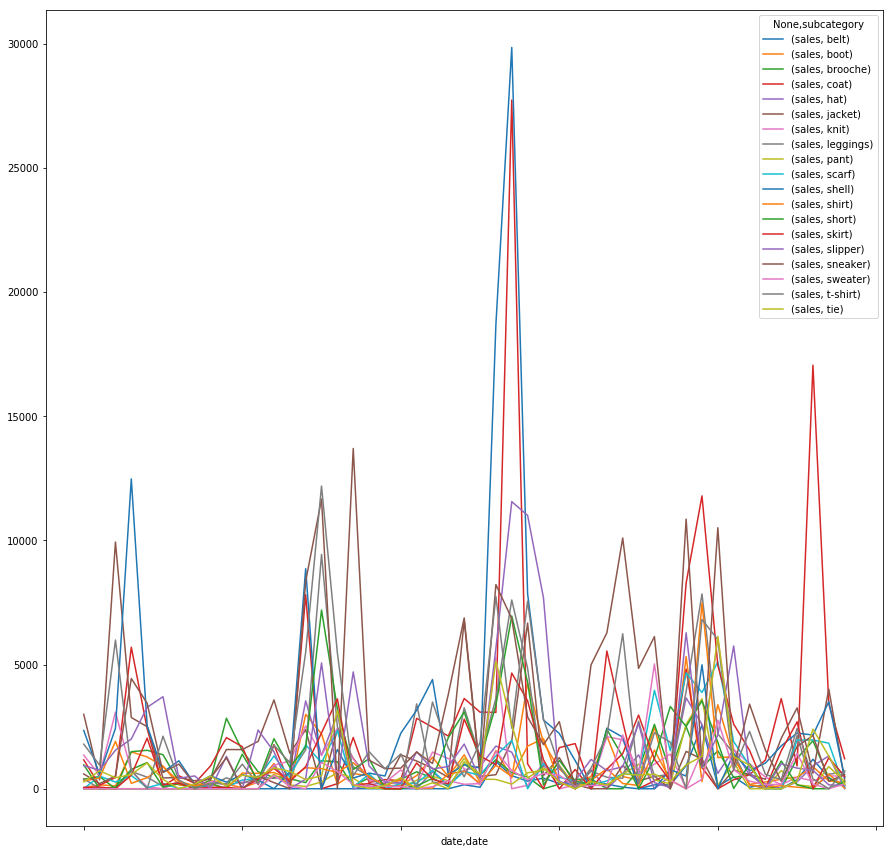

In [4]:
# Visualize monthly sales of products at subcategory level
plot_dataset_ts(product_data, 'subcategory')

## Preparing the dataset for DeepAR

Now that we've generated our raw dataset we need to wrangle it into the format and encoding expected by DeepAR. 

DeepAR expects data (for training or inference) in [JSON Lines](http://jsonlines.org/) or [Parquet](https://parquet.apache.org/) format. For this lab we'll be working with JSON Lines.

In JSON Lines format each line is a seperate JSON object representing a time series for a single product. DeepAR expects each JSON object to have a `start` key, a string or datetime object representing the time the time series data starts at, and a `target` key, whose value is an array of floats (or integers) that represent the time series variable’s values. Additionally each JSON object can include a `cat` key, which is an integer that encodes the categorical grouping that record’s time series is a member of. This allows the model to learn typical behavior for that group and can increase accuracy.

Currently our product sales data is in a pandas DataFrame and is not yet converted into JSON objects with time series grouped by product ID as the DeepAR algorithm expects for training. In the following cells we'll wrangle the data into the required format.

To start, our categorical grouping values (product category and subcategory) are currently strings but DeepAR expects integers for these values. Let's encode our category and subcategory values to integers to use for our `cat` values.

In [5]:
uniq_cats = product_data.category.unique().tolist()
uniq_subcats = product_data.subcategory.unique().tolist()

le = LabelEncoder().fit((uniq_cats + uniq_subcats))
print(le.classes_)

['accessories' 'belt' 'boot' 'bottom' 'brooche' 'coat' 'hat' 'jacket'
 'knit' 'leggings' 'outerwear' 'pant' 'scarf' 'shell' 'shirt' 'shoe'
 'short' 'skirt' 'slipper' 'sneaker' 'sweater' 't-shirt' 'tie' 'top']


As you can see we've encoded class labels for both the product subcategories and the categories. Later we will see how this allows us to make forecasting predictions for existing product subcategories at a granular level while also allowing us to generalize our predictions to new subcategories that we might wish to introduce by predicting at the higher category level.

Next we set the epochs, frequency, prediction length, context length, cardinality, and embedding dimension hyperparameters we wish to train our DeepAR model on.

Epochs specifies the maximum number of times to pass over the data when training. For this lab we set the value to '50' to minimize training job runtime due to time constraints.

Frequency specifies the granularity of the time series in the dataset. In this case out time series values correspond to daily sales results for each product so our frequency is 'D' for daily. Other possible values are 'min' (every minute), 'H' (hourly), 'W' (weekly), and 'M' (monthly).

Prediction length controls the number of time steps (based off the unit of frequency) that the model is trained to predict, also called the forecast horizon. Our prediction length is set to '28' to predict roughly a month's worth of days into the future for forecast requests submitted to the trained DeepAR model.

Context length controls the the number of time points that the model gets to see before making a prediction. The value for this parameter should be about the same as the prediction_length. The model also receives lagged inputs from the target, so context_length can be much smaller than typical seasonalities. For example, a daily time series can have yearly seasonality. The model automatically includes a lag of one year, so the context length can be shorter than a year. The lag values that the model picks depend on the frequency of the time series. For example, lag values for daily frequency are the previous week, 2 weeks, 3 weeks, 4 weeks, and year. Here we set it to '28' to predict based off roughly the last month's worth of time points.

Cardinality is only required when specifying categorical level groupings in your data, and controls the number of unique categories found in your dataset. The label encoder we trained already has a set of the unique classes found in our dataset so we can use the length of this set as our cardinality.

Embedding dimension is only required when specifying categorical level groupings in your data, and specifies the size of the embedding vector the algorithm can learn to capture the common properties of all the time series within a categorical level grouping. Because of the small size of our dataset we leave set this to '2'. For larger datasets with more unique categories this value commonly ranges from 10-100.

Values for the epochs, frequency, prediction length, and context length hyperparameters are required when training a DeepAR model, but you can also configure other optional hyperparameters to further tune your model. For a more exhaustive list of all the different DeepAR hyperparameters you can tune [check out the DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html).

In [6]:
epochs = '50'
freq = 'D'
prediction_length = '28'
context_length = '28'
cardinality = str(len(le.classes_))
embedding_dimension = '2'

hyperparameters = {
    "epochs": epochs,
    "time_freq": freq,
    "context_length": context_length,
    "prediction_length": prediction_length,
    "cardinality": cardinality,
    "embedding_dimension": embedding_dimension
}

Next we transform our pandas DataFrame into JSON objects for each product ID as expected by the DeepAR algorithm. This transformation is implemented in the `transform_to_json_objs` helper function created at the start of this notebook for reference.

The DeepAR algorithm has an optional test channel for training that can be used to calculate accuracy metrics for the model after training, such as RMSE and quantile loss. For our test set we'll use the full time series for each product. For our training set we'll use the full time series minus our prediction length worth of time points. The loss for our model will then be calculated by how well our model predicts these missing time points in comparison to the ground truth values.

In [7]:
json_objs = transform_to_json_objs(product_data, le)
train_set = make_train_set(json_objs, int(prediction_length))
test_set = json_objs

Lastly we upload our data to S3 so it can be accessed by the DeepAR algorithm during the training job. The SageMaker `Session` class has a convenient method, [`upload_data`](http://sagemaker.readthedocs.io/en/latest/session.html#sagemaker.session.Session.upload_data), to help us upload our training and testing data to S3 while also returning S3 URIs to pass to our training job.

In [8]:


resource_prefix = 'deepar-retail-forecast'

sagemaker_session = sagemaker.Session()

train_file = write_json_to_file(train_set, 'train')
test_file = write_json_to_file(test_set, 'test')

train_location = sagemaker_session.upload_data(train_file, key_prefix=resource_prefix)
test_location = sagemaker_session.upload_data(test_file, key_prefix=resource_prefix)

## Training and deploying a DeepAR model

DeepAR is one of SageMaker's [built-in algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) so a container for training and hosting the algorithm is provided by the service. Here we select the container corresponding to the region we're running our notebook in and specify the output path in S3 for our SageMaker training job to output trained model artifacts.

In [9]:
role = sagemaker.get_execution_role()

region = "ap-northeast-1"
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

bucket = sagemaker_session.default_bucket()

s3_output_path = "{}/{}/output".format(bucket, resource_prefix)

Next we create an [Estimator](http://sagemaker.readthedocs.io/en/latest/estimators.html) object for our DeepAR model, which is a high level interface for training and deploying SageMaker models programatically, and configure it with the hyperparameters we set earlier.

In [10]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c5.2xlarge',
    base_job_name=resource_prefix,
    output_path="s3://" + s3_output_path
)

estimator.set_hyperparameters(**hyperparameters)

Next we specify the input data channels using the S3 URIs returned earlier when we uploaded our train and test datasets to S3 and fit the DeepAR model. Note that this cell may take 5-15 minutes to run to run to completion.

In [11]:
data_channels = {
    "train": train_location,
    "test": test_location
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: deepar-retail-forecast-2018-10-05-00-01-37-681


...................
Arguments: train
[10/05/2018 00:04:34 INFO 140112055437120] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[10/05/2018 00:04:34 INFO 140112055437120] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'prediction_length': u'28', u'epochs': u'50', u'embedding_dimension': u'2', u'time_freq': u'D', u'context_length': u'28', u'cardinality': u'24'}
[10/05/2018 00:04:34 INFO 140112055437120] Final configuration: {u'

[10/05/2018 00:04:44 INFO 140112055437120] Epoch[6] Batch[0] avg_epoch_loss=2.173451
[10/05/2018 00:04:45 INFO 140112055437120] Epoch[6] Batch[5] avg_epoch_loss=2.378575
[10/05/2018 00:04:45 INFO 140112055437120] Epoch[6] Batch [5]#011Speed: 1182.09 samples/sec#011loss=2.378575
[10/05/2018 00:04:46 INFO 140112055437120] Epoch[6] Batch[10] avg_epoch_loss=2.353907
[10/05/2018 00:04:46 INFO 140112055437120] Epoch[6] Batch [10]#011Speed: 1191.18 samples/sec#011loss=2.324304
[10/05/2018 00:04:46 INFO 140112055437120] processed a total of 1425 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1663.7308597564697, "sum": 1663.7308597564697, "min": 1663.7308597564697}}, "EndTime": 1538697886.167887, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538697884.50398}

[10/05/2018 00:04:46 INFO 140112055437120] #throughput_metric: host=algo-1, train throughput=856.462823958 records/second
[10/05/2018 00:04:46 INFO 140112055437120] #

[10/05/2018 00:05:04 INFO 140112055437120] Epoch[18] Batch[5] avg_epoch_loss=1.897918
[10/05/2018 00:05:04 INFO 140112055437120] Epoch[18] Batch [5]#011Speed: 1218.50 samples/sec#011loss=1.897918
[10/05/2018 00:05:05 INFO 140112055437120] Epoch[18] Batch[10] avg_epoch_loss=1.924938
[10/05/2018 00:05:05 INFO 140112055437120] Epoch[18] Batch [10]#011Speed: 1190.87 samples/sec#011loss=1.957363
[10/05/2018 00:05:05 INFO 140112055437120] processed a total of 1396 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1560.755968093872, "sum": 1560.755968093872, "min": 1560.755968093872}}, "EndTime": 1538697905.396175, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538697903.835246}

[10/05/2018 00:05:05 INFO 140112055437120] #throughput_metric: host=algo-1, train throughput=894.388486325 records/second
[10/05/2018 00:05:05 INFO 140112055437120] #progress_metric: host=algo-1, completed 38 % of epochs
[10/05/2018 00:05:05 INFO 14

[10/05/2018 00:05:25 INFO 140112055437120] Epoch[31] Batch[0] avg_epoch_loss=1.873826
[10/05/2018 00:05:25 INFO 140112055437120] Epoch[31] Batch[5] avg_epoch_loss=1.682265
[10/05/2018 00:05:25 INFO 140112055437120] Epoch[31] Batch [5]#011Speed: 1213.47 samples/sec#011loss=1.682265
[10/05/2018 00:05:26 INFO 140112055437120] Epoch[31] Batch[10] avg_epoch_loss=1.659698
[10/05/2018 00:05:26 INFO 140112055437120] Epoch[31] Batch [10]#011Speed: 1209.25 samples/sec#011loss=1.632619
[10/05/2018 00:05:26 INFO 140112055437120] processed a total of 1434 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1667.1960353851318, "sum": 1667.1960353851318, "min": 1667.1960353851318}}, "EndTime": 1538697926.352666, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538697924.685303}

[10/05/2018 00:05:26 INFO 140112055437120] #throughput_metric: host=algo-1, train throughput=860.084617486 records/second
[10/05/2018 00:05:26 INFO 140112055437

[10/05/2018 00:05:44 INFO 140112055437120] Epoch[43] Batch[5] avg_epoch_loss=1.621925
[10/05/2018 00:05:44 INFO 140112055437120] Epoch[43] Batch [5]#011Speed: 1196.90 samples/sec#011loss=1.621925
[10/05/2018 00:05:45 INFO 140112055437120] Epoch[43] Batch[10] avg_epoch_loss=1.598677
[10/05/2018 00:05:45 INFO 140112055437120] Epoch[43] Batch [10]#011Speed: 1205.96 samples/sec#011loss=1.570780
[10/05/2018 00:05:45 INFO 140112055437120] processed a total of 1360 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1542.8738594055176, "sum": 1542.8738594055176, "min": 1542.8738594055176}}, "EndTime": 1538697945.353332, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538697943.810248}

[10/05/2018 00:05:45 INFO 140112055437120] #throughput_metric: host=algo-1, train throughput=881.416495756 records/second
[10/05/2018 00:05:45 INFO 140112055437120] #progress_metric: host=algo-1, completed 88 % of epochs
[10/05/2018 00:05:45 INFO


#metrics {"Metrics": {"get_graph.time": {"count": 1, "max": 158.9970588684082, "sum": 158.9970588684082, "min": 158.9970588684082}}, "EndTime": 1538697954.837196, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538697954.677668}

[10/05/2018 00:05:54 INFO 140112055437120] Number of GPUs being used: 0
#metrics {"Metrics": {"finalize.time": {"count": 1, "max": 220.95203399658203, "sum": 220.95203399658203, "min": 220.95203399658203}}, "EndTime": 1538697954.899108, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538697954.837258}

[10/05/2018 00:05:54 INFO 140112055437120] Serializing to /opt/ml/model/model_algo-1
[10/05/2018 00:05:54 INFO 140112055437120] Saved checkpoint to "/opt/ml/model/model_algo-1-0000.params"
#metrics {"Metrics": {"model.serialize.time": {"count": 1, "max": 10.873079299926758, "sum": 10.873079299926758, "min": 10.873079299926758}}, "EndTime": 1538697954.91006, "

In [12]:
import cv2

Lastly we deploy our trained model to a SageMaker model endpoint where we can leverage it for forecasting predictions. 

In [13]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    endpoint_name=resource_prefix,
    content_type="application/json"
)

INFO:sagemaker:Creating model with name: forecasting-deepar-2018-10-05-00-06-21-200
INFO:sagemaker:Creating endpoint with name deepar-retail-forecast


---------------------------------------------------------------!

## Leveraging deployed DeepAR model endpoint for forecasting predictions

Now that we have a SageMaker model endpoint deployed let's use it to make some predictions. DeepAR model endpoints expect requests in JSON format with the following keys:

`instances` - A list of the time series that should be forecast by the model. Each entry in the list should be a JSON object in the same format that DeepAR expects for training.

`configuration` - Optional. A dictionary of configuration information for the type of response desired by the request.

Within `configuration` the following keys can be configured:

`num_samples` - An integer specifying the number of sample paths that the model generates when making a probabilistic prediction.

`output_types` - A list specifying the type of response. `mean` returns a single value for each time point which is the average of `num_samples` samples generated by the model. `quantiles` looks at the list of `num_samples` generated by the model and attempts to generate quantile estimates for each time point based on these values. `samples` returns the list of `num_samples` for each time point in the prediction length. 

`quantiles` - If your specify `quantiles` as one of your desired output types then this list lets you control which quantiles estimates are generated and returned for in the response.

Below is an example of what a JSON query to a DeepAR model endpoint might look like.

```json
{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0], "cat": 0},
  { "start": "2012-01-30", "target": [1.0], "cat": 2 },
  { "start": "1999-01-30", "target": [2.0, 1.0], "cat": 1 }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["mean", "quantiles", "samples"],
  "quantiles": ["0.5", "0.9"]
 }
}
```

In the cells below you can try predictions for a sample item with existing time series taken from our testing dataset as well as a prediction for a new "cold" item with no existing time series.

[3, 3, 4, 3, 3, 4, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 21, 20, 19, 18, 19]
[3.5644078255, 3.6695723534, 3.6002216339, 3.8611161709, 3.1019284725, 3.5250012875, 3.15427351, 3.4910783768, 2.942700386, 3.4433922768, 3.0300498009, 3.3061096668, 4.3432102203, 4.3284974098, 4.3495154381, 3.6626884937, 3.8949878216, 3.8115239143, 3.0309150219, 3.5373806953, 3.09248209, 2.708231926, 2.6186385155, 2.6408231258, 1.2298727036, 3.8777894974, 3.0082397461, 2.6584146023]


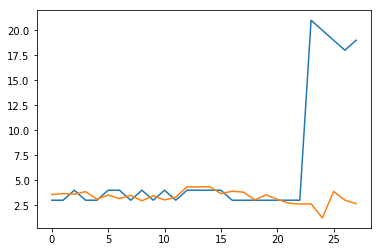

In [14]:
# Prediction for item with existing time series sales history

start_date = datetime.date.today() - datetime.timedelta(days=int(prediction_length)+28)

target = test_set[0]['target'][-int(prediction_length)-28:-28]

cat = test_set[0]['cat']

request_json = {
 "instances": [
  { "start": str(start_date), "target": target, "cat": cat}
 ],
 "configuration": {
  "num_samples": 10,
  "output_types": ["samples"],
 # "quantiles": ["0.9"]
 }
}

payload = json.dumps(request_json).encode('utf-8')

response = predictor.predict(payload)

print(test_set[0]['target'][-int(prediction_length):])
result = json.loads(response)
print(result['predictions'][0]['samples'][0])

import numpy as np
import matplotlib.pyplot as plt
 
# 折れ線グラフを出力
plt.plot(test_set[0]['target'][-int(prediction_length):])
plt.plot(result['predictions'][0]['samples'][0])

In [15]:
# Cold-start prediction for new item that has no time series sales history

product_category = 'shoe'

cat = int(le.transform([product_category])[0])

request_json = {
 "instances": [
  {"start": "2019-06-12 00:00:00", "target": [], "cat": cat} # No target values because this is a new product with no existing time series sales data
 ],
 "configuration": {
  "num_samples": 10,
  "output_types": ["quantiles"],
  "quantiles": ["0.9"]
 }
}

payload = json.dumps(request_json).encode('utf-8')

response = predictor.predict(payload)

print(response)

b'{"predictions":[{"quantiles":{"0.9":[5.886097908,5.9440250397,5.8689446449,8.9992074966,5.8916120529,7.427611351,8.1236610413,7.4500861168,8.7738628387,8.4529256821,8.0915660858,10.4717330933,9.0055541992,8.7730197906,9.0465946198,9.3524198532,10.5117521286,9.8222112656,10.6573915482,9.4605903625,8.0283384323,6.7257905006,10.083067894,8.4854278564,8.798377037,7.9051833153,8.5901708603,8.0265102386]}}]}'
